In [3]:
############################### MISE EN PLACE DU CNN
import torch
from torch.autograd import Variable
from torch.optim import Adam, SGD

import torch.nn as nn
import torch.optim as optim

batch_size = 1
epochs = 50
learning_rate = 2e-3

In [4]:
############################## CRÉATION DU DATASET

import torch
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torchaudio
import numpy as np
import matplotlib.image as mpimg
from torch import tensor
import os
from torchvision.transforms import ToTensor
from PIL import Image 
from sklearn.preprocessing import normalize

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)


norm = np.load("../Data/Spec_TEST_SNR_5/Noisy/Modulus/"+ "minmax_db.npy")[2]
print("Norm :", norm)

def my_loader(filename):
    global norm
    spec = np.load(filename)
    spec_db = 20*np.log10(spec) / norm
    return spec_db.astype('float32')


    
data_clear = torchvision.datasets.DatasetFolder('../Data/Spec_TRAIN_SNR_5/Clear/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")
data_noisy = torchvision.datasets.DatasetFolder('../Data/Spec_TRAIN_SNR_5/Noisy/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")

train_loader = torch.utils.data.DataLoader(data_noisy, batch_size=batch_size, shuffle=False, pin_memory=True)
train_loader_clear = torch.utils.data.DataLoader(data_clear, batch_size=batch_size, shuffle=False, pin_memory=True)

Device:  cuda
Norm : -193.0163


In [17]:
############################## CRÉATION DE LA CLASSE AUTO-ENCODEUR

import torch.nn as nn
class AE(nn.Module):
    def __init__(self, **kwargs):
        
        # Définition des couches du réseau
        super().__init__()
        self.encoder_hidden_layer1 = nn.Conv2d(
            in_channels=1, out_channels=100, kernel_size=(3, 3), stride=1, padding=(3,3), groups=1
        )
        self.encoder_hidden_layer2 = nn.Conv2d(
            in_channels=100, out_channels=500, kernel_size=(3, 3), stride=1, padding=(2,2), groups=1
        )
        self.encoder_hidden_layer3 = nn.Conv2d(
            in_channels=500, out_channels=2000, kernel_size=(3, 3), stride=1, padding=(0, 0), groups=1
        )
        self.poolp = nn.MaxPool2d(
            kernel_size=2, padding=(0,1)
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.avgpool = nn.AvgPool2d(
            kernel_size=2
        )
        self.upsample = nn.Upsample(
            scale_factor=2, mode='nearest'
        )
        self.decoder_hidden_layer1 = nn.ConvTranspose2d(
            in_channels=2000, out_channels=500, kernel_size=(3,3), stride=2, padding=(0,0), groups=1
        )
        self.decoder_hidden_layer2 = nn.ConvTranspose2d(
            in_channels=500, out_channels=100, kernel_size=(3, 3), stride=2, padding=(0,0), groups=1
        )
        self.decoder_output_layer = nn.ConvTranspose2d(
            in_channels=100, out_channels=1, kernel_size=(3, 3), stride=2, padding=(3,1), groups=1
        )
    
    # Application séquentielle des couches du réseau
    def forward(self, features):
        encode1 = self.encoder_hidden_layer1(features)
        encode1 = torch.relu(encode1)
        encode1 = self.pool(encode1)

        encode2 = self.encoder_hidden_layer2(encode1)
        encode2 = torch.relu(encode2)
        encode2 = self.pool(encode2)

        encode3 = self.encoder_hidden_layer3(encode2)
        encode3 = torch.relu(encode3)
        encode3 = self.pool(encode3)

        decode1 = self.decoder_hidden_layer1(encode3)
        decode1 = torch.relu(decode1)

        decode2 = self.decoder_hidden_layer2(decode1)
        decode2 = torch.relu(decode2)

        decode3 = self.decoder_output_layer(decode2)
        decode3 = torch.sigmoid(decode3)

        decode3 = decode3[:, :, 0:features.size()[2], 0:features.size()[3]]
        return decode3
        
 



In [18]:
############################## INITIALISATION DU MODÈLE

if (device == "cuda"):
    torch.cuda.empty_cache()

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)


# mean-squared error loss
criterion = nn.MSELoss()

In [1]:
############################## ENTRAINEMENT DU RESEAU

for epoch in range(epochs):
    loss = 0
#     for batch_features, _ in test_loader:
    for [batch_features,_],[batch_features_clear,_] in zip(train_loader, train_loader_clear):
        batch_features = batch_features.to(device)
        batch_features_clear = batch_features_clear.to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features.clone().detach())

        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features_clear)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        del train_loss
        del outputs
        
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # save the weigth
    torch.save(model.state_dict(), "model/model"+str(epoch+1)+".pt")
    
    # display the epoch training loss
    print("epoch : {}/{}, Training loss = {:.8f}".format(epoch + 1, epochs, loss))

Text(0.5, 1.0, 'Output')

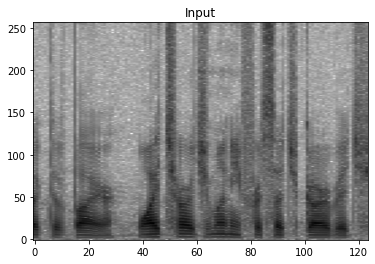

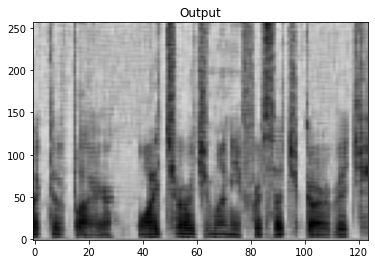

In [19]:
########################### PREDICTION

# Chargement du dataset de test

data_clear = torchvision.datasets.DatasetFolder('../Data/Spec_TEST_SNR_5/Clear/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")
data_noisy = torchvision.datasets.DatasetFolder('../Data/Spec_TEST_SNR_5/Noisy/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")

test_loader = torch.utils.data.DataLoader(data_noisy, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader_clear = torch.utils.data.DataLoader(data_clear, batch_size=batch_size, shuffle=False, pin_memory=True)

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)
# model = autoencoder().to(device)


# load model
model.load_state_dict(torch.load("model/model50.pt"))
model.eval()

# Evalutation du modèle et enregistrement des prédictions
with torch.no_grad():
    i=0
    for batch_features, _ in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features.clone().detach())
        for j in range(len(outputs[0])):
            np.save('../Data/Spec_TEST_SNR_5/Noisy/Predict/output_' + str(i) + '.npy', outputs.cpu().numpy().astype(np.float32))
            i+=1


plt.figure(0)
plt.imshow(batch_features.cpu().numpy()[0][0], cmap='gray', aspect='auto', origin='lower')
plt.title("Input")

plt.figure(1)
plt.imshow(outputs.cpu().numpy()[0][0], cmap='gray', aspect='auto', origin='lower')
plt.title("Output")

Text(0.5, 1.0, 'Reconstruit')

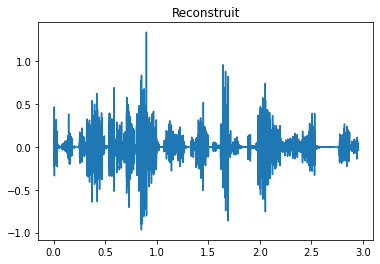

In [12]:
########################### RECONSTRUCTION EN TEMPOREL

import os
from scipy.signal import istft
import cmath
from scipy.io.wavfile import write
nprect = np.vectorize(cmath.rect)

parameters = np.load("../Data/parameters.npy", allow_pickle=True)
sample_rate = parameters[0]
t_br = parameters[1]
f_br = parameters[2]


dataset_path = '../Data/Spec_TEST_SNR_5/Noisy/'


list_subpath_phi = []
list_subpath_mod = []

for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        if ('phi' in file):
            list_subpath_phi.append(os.path.join(subdir, file))
        if ('output' in file):
            list_subpath_mod.append(os.path.join(subdir, file))

            
# Dénormalisation et mise en forme du spéctrogramme en module
# Calcul de la TF inverse et enregistrement audio en .wav
for i in range(len(list_subpath_phi)):
    phase = np.load(list_subpath_phi[i])
    magnitude = np.load(list_subpath_mod[i])
    magnitude = 10**(magnitude*norm/20)
    spec = nprect(magnitude, phase)
    sig = istft(spec, fs=sample_rate, nfft=512, nperseg=512, noverlap=128)
    number = list_subpath_phi[i].split('/')[-1].split('_')[2] + "_" + list_subpath_phi[i].split('/')[-1].split('_')[3]
    write(dataset_path+"Reconstruct/r_sig_"+number+".wav", sample_rate, sig[1])


plt.figure(0)
plt.plot(np.array(range(len(sig[1][0][0])))/sample_rate, sig[1][0][0])
plt.title("Reconstruit")

In [59]:
########################### CALCUL DU RSB GLOBAL

P_rec = 0
P_wav = 0
for subdir, dirs, files in os.walk("../Data/meme_taille_TEST/"):
    for file in files:
        waveform, _ = torchaudio.load(os.path.join(subdir, file))
        reconstruct, _ = torchaudio.load("../Data/Spec_TEST_SNR_5/Noisy/Reconstruct/r_"+file.lower())
        wav = waveform[0].t().numpy()
        wav = wav/(np.max(wav)-np.min(wav))
        rec = reconstruct[0].t().numpy()
        rec = rec/(np.max(rec)-np.min(rec))
        P_wav+=(sum(abs(wav)**2))
        P_rec+=(sum(abs(rec)**2))
RSB = P_wav/P_rec

print("RSB total:", RSB)

RSB total: 1.6491850842811773
